# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -2 * np.ones((dim_full, 1))
ub = 2 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

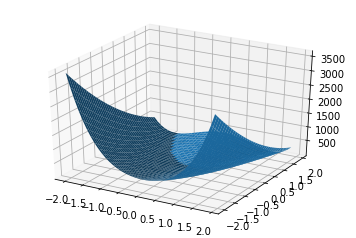

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()
n_starts = 20

result1 = pypesto.minimize(problem=problem1, optimizer=optimizer, n_starts=n_starts)
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer, n_starts=n_starts)

## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

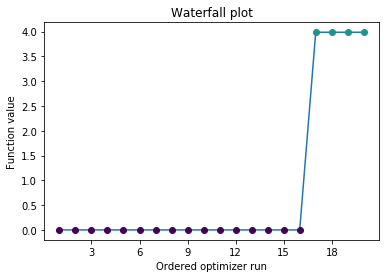

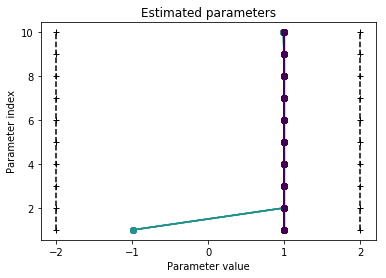

In [5]:
import pypesto.visualize

pypesto.visualize.waterfall(result1)
pypesto.visualize.parameters(result1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [6]:
result1.optimize_result.as_dataframe(['fval', 'n_fval', 'n_grad', 'n_hess', 'n_res', 'n_sres', 'time'])

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,1.023675e-12,77,77,0,0,0,0.053963
1,1.061637e-12,80,80,0,0,0,0.045351
2,1.701675e-12,76,76,0,0,0,0.055039
3,2.654868e-12,68,68,0,0,0,0.076167
4,4.658676e-12,70,70,0,0,0,0.053466
5,5.454840e-12,88,88,0,0,0,0.055733
6,9.106136e-12,81,81,0,0,0,0.052232
7,1.389431e-11,87,87,0,0,0,0.044941
8,2.863107e-11,86,86,0,0,0,0.053060
9,3.929462e-11,91,91,0,0,0,0.056752
